<a href="https://colab.research.google.com/github/Thamindu17/google-colab/blob/main/Linearactivetime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving large.csv to large.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
import pandas as pd
data = pd.read_csv("large.csv")
data.head()
data.tail()

,Weeknumber,TotalActiveTime,Subject,Class,SpecialEventThisWeek,ResourcesUploadedThisWeek
115,116,1020.3,Science,7-A,1,6
116,117,933.4,Science,7-A,1,1
117,118,829.6,Science,7-A,0,4
118,119,970.6,Science,7-A,1,3
119,120,784.1,Science,7-A,0,1


In [4]:
data['PrevWeekActiveTime'] = data['TotalActiveTime'].shift(1)
data['Prev2WeekActiveTime'] = data['TotalActiveTime'].shift(2)
data['RollingMean3'] = data['TotalActiveTime'].shift(1).rolling(window=3).mean()
data['RollingMean5'] = data['TotalActiveTime'].shift(1).rolling(window=5).mean()
data['InteractionTerm'] = data['SpecialEventThisWeek'] * data['ResourcesUploadedThisWeek']
data = data.dropna()  # Drop NA due to lag/rolling


In [5]:
# Use first 100 weeks for training, last 20 for testing
train = data.iloc[:100]
test = data.iloc[100:]

X_train = train[['SpecialEventThisWeek', 'ResourcesUploadedThisWeek',
                 'PrevWeekActiveTime', 'Prev2WeekActiveTime',
                 'RollingMean3', 'RollingMean5', 'InteractionTerm']]
y_train = train['TotalActiveTime']

X_test = test[['SpecialEventThisWeek', 'ResourcesUploadedThisWeek',
                'PrevWeekActiveTime', 'Prev2WeekActiveTime',
                'RollingMean3', 'RollingMean5', 'InteractionTerm']]
y_test = test['TotalActiveTime']


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lr))


Linear Regression R²: 0.9745774820948542
Linear Regression MSE: 180.03535235981403


In [7]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))


Random Forest R²: 0.9697789186075344
Random Forest MSE: 214.0174729146659


In [8]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_test)

print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("XGBoost MSE:", mean_squared_error(y_test, y_pred_xgb))


XGBoost R²: 0.9751398840423483
XGBoost MSE: 176.05257484097248


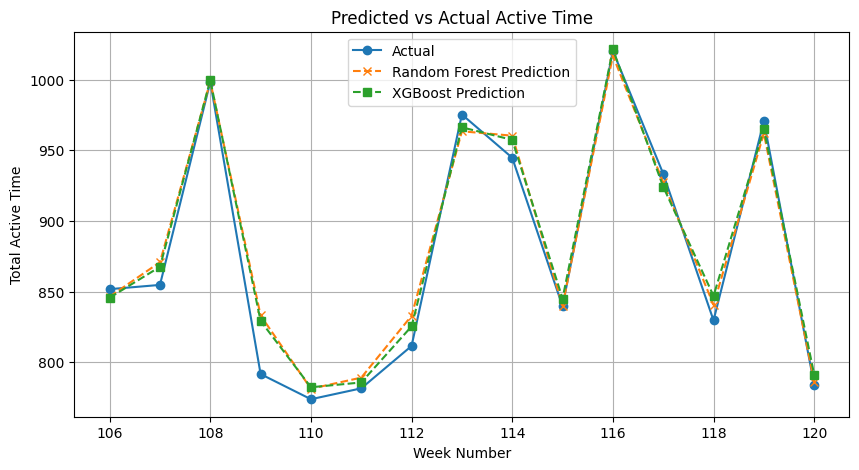

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(test['Weeknumber'], y_test.values, label='Actual', marker='o')
plt.plot(test['Weeknumber'], y_pred_rf, label='Random Forest Prediction', linestyle='--', marker='x')
plt.plot(test['Weeknumber'], y_pred_xgb, label='XGBoost Prediction', linestyle='--', marker='s')
plt.xlabel("Week Number")
plt.ylabel("Total Active Time")
plt.title("Predicted vs Actual Active Time")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
latest_data = data.sort_values(by='WeekNumber').tail(5).copy()

# Input only known future values
future_input = pd.DataFrame({
    "SpecialEventThisWeek": [0, 0, 1],
    "ResourcesUploadedThisWeek": [5, 2, 4]
})

# Create full future DataFrame with features
future_full = []

for i in range(len(future_input)):
    # Extract lag features from latest known/simulated values
    prev_week_time = latest_data.iloc[-1]['TotalActiveTime']
    prev2_week_time = latest_data.iloc[-2]['TotalActiveTime']
    rolling_mean3 = latest_data['TotalActiveTime'].iloc[-3:].mean()
    rolling_mean5 = latest_data['TotalActiveTime'].iloc[-5:].mean()

    row = future_input.iloc[i]
    row_data = {
        'SpecialEventThisWeek': row['SpecialEventThisWeek'],
        'ResourcesUploadedThisWeek': row['ResourcesUploadedThisWeek'],
        'PrevWeekActiveTime': prev_week_time,
        'Prev2WeekActiveTime': prev2_week_time,
        'RollingMean3': rolling_mean3,
        'RollingMean5': rolling_mean5,
        'InteractionTerm': row['SpecialEventThisWeek'] * row['ResourcesUploadedThisWeek']
    }

    # Create row DataFrame
    row_df = pd.DataFrame([row_data])
    future_full.append(row_df)

    # Predict using trained model (Random Forest)
    simulated_time = rf.predict(row_df)[0]

    # Append this result to latest_data for next iteration
    new_row = {
        'WeekNumber': latest_data['WeekNumber'].max() + 1 + i,
        'TotalActiveTime': simulated_time
    }
    latest_data = pd.concat([latest_data, pd.DataFrame([new_row])], ignore_index=True)

# Combine all predictions
future_ready = pd.concat(future_full, ignore_index=True)
future_predictions = rf.predict(future_ready)

print("Predicted TotalActiveTime for future weeks:", future_predictions)

KeyError: 'WeekNumber'

Saving large.csv to large (6).csv
Linear Regression R²: 0.9766704769988389
Linear Regression MSE: 160.97405975338563
Random Forest R²: 0.9721273580020258
Random Forest MSE: 192.32164919288508
XGBoost R²: 0.9752408556159067
XGBoost MSE: 170.83846880750156


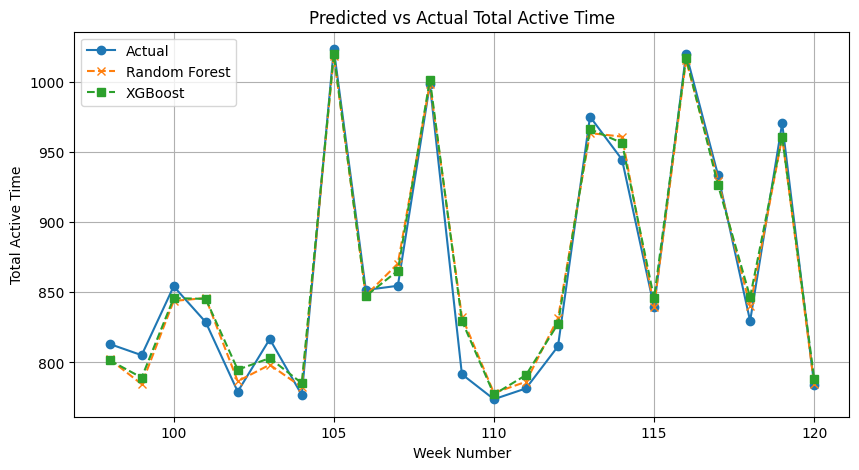

Predicted TotalActiveTime for future weeks: [871.50153523 803.90385556 974.38544374]


In [8]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import train_test_split

# ------------------------------
# Step 1: Load and preprocess data
# ------------------------------
data = pd.read_csv("large.csv")

# Ensure Weeknumber exists, or create it
if 'Weeknumber' not in data.columns:
    data['Weeknumber'] = range(1, len(data) + 1)

# Feature engineering
data['PrevWeekActiveTime'] = data['TotalActiveTime'].shift(1)
data['Prev2WeekActiveTime'] = data['TotalActiveTime'].shift(2)
data['RollingMean3'] = data['TotalActiveTime'].shift(1).rolling(window=3).mean()
data['RollingMean5'] = data['TotalActiveTime'].shift(1).rolling(window=5).mean()
data['InteractionTerm'] = data['SpecialEventThisWeek'] * data['ResourcesUploadedThisWeek']
data = data.dropna().reset_index(drop=True)

# ------------------------------
# Step 2: Train-test split (80-20 time split)
# ------------------------------
split_index = int(len(data) * 0.8)
train = data.iloc[:split_index]
test = data.iloc[split_index:]

X_train = train[['SpecialEventThisWeek', 'ResourcesUploadedThisWeek',
                 'PrevWeekActiveTime', 'Prev2WeekActiveTime',
                 'RollingMean3', 'RollingMean5', 'InteractionTerm']]
y_train = train['TotalActiveTime']

X_test = test[['SpecialEventThisWeek', 'ResourcesUploadedThisWeek',
               'PrevWeekActiveTime', 'Prev2WeekActiveTime',
               'RollingMean3', 'RollingMean5', 'InteractionTerm']]
y_test = test['TotalActiveTime']

# ------------------------------
# Step 3: Train and evaluate models
# ------------------------------

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lr))

# Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))

# XGBoost
xgbr = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_test)
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("XGBoost MSE:", mean_squared_error(y_test, y_pred_xgb))

# ------------------------------
# Step 4: Visualize predictions
# ------------------------------
plt.figure(figsize=(10, 5))
plt.plot(test['Weeknumber'], y_test.values, label='Actual', marker='o')
plt.plot(test['Weeknumber'], y_pred_rf, label='Random Forest', linestyle='--', marker='x')
plt.plot(test['Weeknumber'], y_pred_xgb, label='XGBoost', linestyle='--', marker='s')
plt.xlabel("Week Number")
plt.ylabel("Total Active Time")
plt.title("Predicted vs Actual Total Active Time")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# Step 5: Predict future values using recursive method
# ------------------------------

# Get last 5 rows of actual data (for lag features)
latest_data = data.sort_values(by='Weeknumber').tail(5).copy()

# Input only known future values
future_input = pd.DataFrame({
    "SpecialEventThisWeek": [0, 0, 1],
    "ResourcesUploadedThisWeek": [5, 2, 4]
})

# Create full future DataFrame with features
future_full = []

for i in range(len(future_input)):
    # Extract lag features from latest known/simulated values
    prev_week_time = latest_data.iloc[-1]['TotalActiveTime']
    prev2_week_time = latest_data.iloc[-2]['TotalActiveTime']
    rolling_mean3 = latest_data['TotalActiveTime'].iloc[-3:].mean()
    rolling_mean5 = latest_data['TotalActiveTime'].iloc[-5:].mean()

    row = future_input.iloc[i]
    row_data = {
        'SpecialEventThisWeek': row['SpecialEventThisWeek'],
        'ResourcesUploadedThisWeek': row['ResourcesUploadedThisWeek'],
        'PrevWeekActiveTime': prev_week_time,
        'Prev2WeekActiveTime': prev2_week_time,
        'RollingMean3': rolling_mean3,
        'RollingMean5': rolling_mean5,
        'InteractionTerm': row['SpecialEventThisWeek'] * row['ResourcesUploadedThisWeek']
    }

    # Create row DataFrame
    row_df = pd.DataFrame([row_data])
    future_full.append(row_df)

    # Predict using trained model (Random Forest)
    simulated_time = rf.predict(row_df)[0]

    # Append this result to latest_data for next iteration
    new_row = {
        'Weeknumber': latest_data['Weeknumber'].max() + 1 + i,
        'TotalActiveTime': simulated_time
    }
    latest_data = pd.concat([latest_data, pd.DataFrame([new_row])], ignore_index=True)

# Combine all predictions
future_ready = pd.concat(future_full, ignore_index=True)
future_predictions = rf.predict(future_ready)

print("Predicted TotalActiveTime for future weeks:", future_predictions)


Saving large.csv to large (8).csv
📌 VIF Scores:
                      Feature         VIF
0                      const  558.874724
1       SpecialEventThisWeek    5.101172
2  ResourcesUploadedThisWeek    1.442590
3         PrevWeekActiveTime    1.345228
4        Prev2WeekActiveTime    1.539697
5               RollingMean5    1.826092
6            InteractionTerm    5.494675
Cross-validated R² scores: [0.96360514 0.98579191 0.95925565 0.98164723 0.97619105]
Average R²: 0.9732981978206532
Linear Regression R²: 0.9804794983096667
Linear Regression MSE: 96.8380767492906


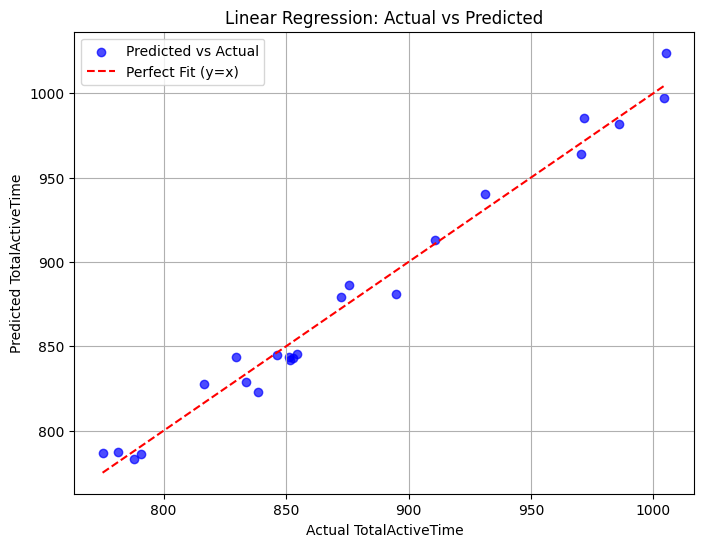

In [11]:
# Upload and import
from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ----------------------------------------
# Step 1: Load and prepare data
# ----------------------------------------
data = pd.read_csv("large.csv")

# Add Weeknumber if not present
if 'Weeknumber' not in data.columns:
    data['Weeknumber'] = range(1, len(data) + 1)

# Feature Engineering
data['PrevWeekActiveTime'] = data['TotalActiveTime'].shift(1)
data['Prev2WeekActiveTime'] = data['TotalActiveTime'].shift(2)
data['RollingMean5'] = data['TotalActiveTime'].shift(1).rolling(window=5).mean()
data['InteractionTerm'] = data['SpecialEventThisWeek'] * data['ResourcesUploadedThisWeek']
data = data.dropna().reset_index(drop=True)

# Features and target
X = data[['SpecialEventThisWeek', 'ResourcesUploadedThisWeek',
          'PrevWeekActiveTime', 'Prev2WeekActiveTime', 'RollingMean5', 'InteractionTerm']]
y = data['TotalActiveTime']

# ----------------------------------------
# Step 2: Multicollinearity Check (VIF)
# ----------------------------------------
X_const = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print("📌 VIF Scores:\n", vif_data)

# ----------------------------------------
# Step 3: Cross-Validation
# ----------------------------------------
lr = LinearRegression()
cv_scores = cross_val_score(lr, X, y, cv=5, scoring='r2')
print("Cross-validated R² scores:", cv_scores)
print("Average R²:", np.mean(cv_scores))

# ----------------------------------------
# Step 4: Train-Test Split & Final Training
# ----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

# Evaluation
print("Linear Regression R²:", r2_score(y_test, y_pred))
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred))

# ----------------------------------------
# Step 5: Plot Actual vs Predicted
# ----------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit (y=x)')
plt.xlabel("Actual TotalActiveTime")
plt.ylabel("Predicted TotalActiveTime")
plt.title("Linear Regression: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()



In [12]:
latest_data = data.sort_values(by='Weeknumber').tail(5).copy()


In [13]:
future_input = pd.DataFrame({
    "SpecialEventThisWeek": [0, 0, 1],
    "ResourcesUploadedThisWeek": [5, 2, 4]
})


In [16]:
future_full = []

for i in range(len(future_input)):
    prev_week_time = latest_data.iloc[-1]['TotalActiveTime']
    prev2_week_time = latest_data.iloc[-2]['TotalActiveTime']

    rolling_mean5 = latest_data['TotalActiveTime'].iloc[-5:].mean()

    row = future_input.iloc[i]
    row_data = {
        'SpecialEventThisWeek': row['SpecialEventThisWeek'],
        'ResourcesUploadedThisWeek': row['ResourcesUploadedThisWeek'],
        'PrevWeekActiveTime': prev_week_time,
        'Prev2WeekActiveTime': prev2_week_time,
        'RollingMean5': rolling_mean5,
        'InteractionTerm': row['SpecialEventThisWeek'] * row['ResourcesUploadedThisWeek']
    }

    row_df = pd.DataFrame([row_data])
    future_full.append(row_df)

    # Predict using trained Linear Regression model
    predicted_time = lr.predict(row_df)[0]

    # Add this prediction to latest_data for next iteration
    new_row = {
        'Weeknumber': latest_data['Weeknumber'].max() + 1 + i,
        'TotalActiveTime': predicted_time
    }
    latest_data = pd.concat([latest_data, pd.DataFrame([new_row])], ignore_index=True)


In [17]:
future_ready = pd.concat(future_full, ignore_index=True)

# Predict TotalActiveTime using trained linear model
future_predictions = lr.predict(future_ready)

print("🔮 Predicted TotalActiveTime for Future Weeks:")
print(future_predictions)


🔮 Predicted TotalActiveTime for Future Weeks:
[865.76474157 807.73991335 982.02242125]
